In [58]:
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets, utils
from sklearn.preprocessing import StandardScaler, MinMaxScaler


## A. Checking and Preprocessing

In [59]:
df = pd.read_csv('nvda.us.txt')
df

,Date,Open,High,Low,Close,Volume,OpenInt
0,1999-01-22,1.6238,1.8092,1.4379,1.5215,18297633,0
1,1999-01-25,1.6423,1.6980,1.5215,1.6793,3445279,0
2,1999-01-26,1.6980,1.7350,1.5311,1.5494,2320993,0
3,1999-01-27,1.5586,1.5957,1.4660,1.5494,1662658,0
4,1999-01-28,1.5494,1.5586,1.5311,1.5401,1540110,0
...,...,...,...,...,...,...,...
4728,2017-11-06,207.2000,209.9800,206.7000,209.6300,9731783,0
4729,2017-11-07,210.5500,212.9000,210.0560,212.0000,10671815,0
4730,2017-11-08,211.8500,212.0000,207.2400,209.1600,13033902,0
4731,2017-11-09,205.2700,206.3300,200.3700,205.3200,23895006,0


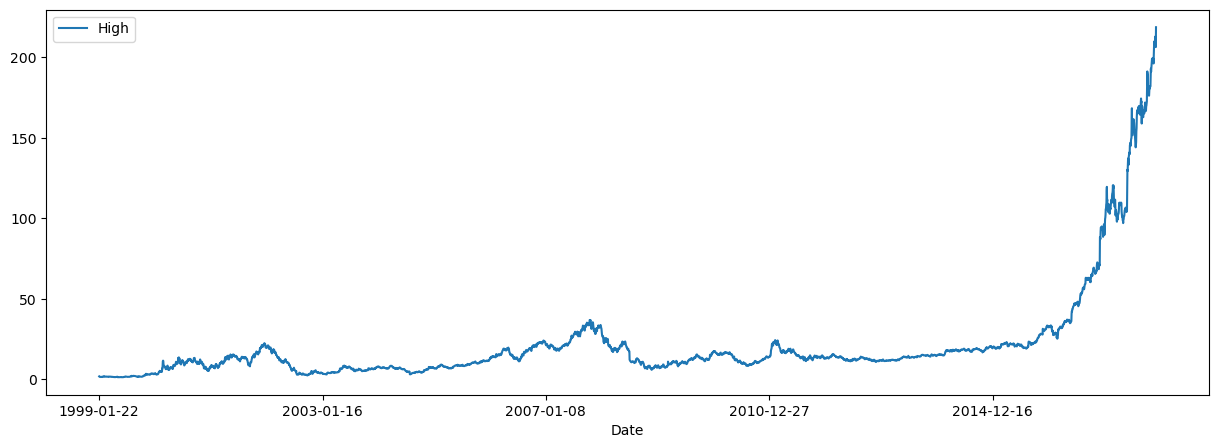

In [60]:
plot = df.plot('Date', 'High', figsize=(15, 5))

In [61]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt'], dtype='object')

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4733 entries, 0 to 4732
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     4733 non-null   object 
 1   Open     4733 non-null   float64
 2   High     4733 non-null   float64
 3   Low      4733 non-null   float64
 4   Close    4733 non-null   float64
 5   Volume   4733 non-null   int64  
 6   OpenInt  4733 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 259.0+ KB


In [63]:
# checking for null values
df.isnull().sum()

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64

In [64]:
df = df.dropna()

In [65]:
df.shape

(4733, 7)

In [66]:
norm_data = df.copy()

## 全部標準化
# norm_data['Date'] = pd.to_datetime(norm_data['Date'])
# title_train = norm_data.keys()
# for col in title_train:
#     try:
#         norm_data[col] = (norm_data[col] - norm_data[col].min()) / (norm_data[col].max() - norm_data[col].min())
#     except TypeError:
#         continue
# norm_data.shape


scaler = MinMaxScaler(feature_range=(0,1))
norm_data[[ 'Open','High','Low','Close']]=scaler.fit_transform(df[[ 'Open','High','Low','Close']])

In [67]:
print(norm_data)

            Date      Open      High       Low     Close    Volume  OpenInt
0     1999-01-22  0.001534  0.002262  0.000970  0.001208  18297633        0
1     1999-01-25  0.001621  0.001751  0.001367  0.001942   3445279        0
2     1999-01-26  0.001884  0.001921  0.001413  0.001338   2320993        0
3     1999-01-27  0.001226  0.001280  0.001103  0.001338   1662658        0
4     1999-01-28  0.001183  0.001109  0.001413  0.001295   1540110        0
...          ...       ...       ...       ...       ...       ...      ...
4728  2017-11-06  0.972235  0.960019  0.976568  0.969704   9731783        0
4729  2017-11-07  0.988054  0.973453  0.992519  0.980733  10671815        0
4730  2017-11-08  0.994192  0.969313  0.979135  0.967516  13033902        0
4731  2017-11-09  0.963122  0.943226  0.946482  0.949646  23895006        0
4732  2017-11-10  1.000000  1.000000  1.000000  1.000000  31300857        0

[4733 rows x 7 columns]


In [68]:
norm_data.describe()

,Open,High,Low,Close,Volume,OpenInt
count,4733.000000,4733.000000,4733.000000,4733.000000,4.733000e+03,4733.0
mean,0.092064,0.091280,0.091192,0.090952,1.615287e+07,0.0
std,0.142771,0.140857,0.141604,0.140841,1.272446e+07,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0
25%,0.031586,0.031886,0.031001,0.031260,8.181100e+06,0.0
50%,0.055076,0.054844,0.054597,0.054580,1.390271e+07,0.0
75%,0.084248,0.083277,0.083386,0.083043,2.051602e+07,0.0
max,1.000000,1.000000,1.000000,1.000000,2.496659e+08,0.0


In [69]:
df.describe()

,Open,High,Low,Close,Volume,OpenInt
count,4733.000000,4733.000000,4733.000000,4733.000000,4.733000e+03,4733.0
mean,20.796242,21.157332,20.420417,20.805404,1.615287e+07,0.0
std,30.236284,30.615622,29.792958,30.263705,1.272446e+07,0.0
min,1.298900,1.317500,1.233900,1.261900,0.000000e+00,0.0
25%,7.988300,8.247900,7.756400,7.978900,8.181100e+06,0.0
50%,12.963000,13.238000,12.721000,12.990000,1.390271e+07,0.0
75%,19.141000,19.418000,18.778000,19.106000,2.051602e+07,0.0
max,213.080000,218.670000,211.630000,216.140000,2.496659e+08,0.0


#### Converting the DataFrame to a NumPy Array

In [70]:
def create_sequences(input_data, output_data, window_size, step):  
    sequences = []
    labels = []
    for i in range(0, len(input_data) - window_size, step):
        sequences.append(input_data[i:(i + window_size)])
        labels.append(output_data[i + window_size])
    return np.array(sequences), np.array(labels)

In [71]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt


# Select features
features = df[[ 'Open','High','Low']] ###取Volume  ##需要把這四個都當input嗎 還是拿特定幾個當input feature就好?
labels = df['High'].shift(-1)  # Next day's high price as label

X, y = create_sequences(features, labels, window_size=20, step=5) ## 從第一天開始抓10個 預測第11天的股價，step:當10天包好之後 會跳15個 為甚麼要大於window_size?

print(f'Shape of data X: {X.shape}')
print(f'Shape of data y: {y.shape}')

# split the hold-out tests
ind = np.linspace(0, len(X)-1, num=int(len(X)*0.1), dtype=int) # 10% hold-out
x_test = X[ind]
y_test = y[ind]
all_ind = np.arange(len(X))
remains_ind = np.delete(all_ind, ind)

X = X[remains_ind]
y = y[remains_ind]

# shuffle dataset
ind = np.random.permutation(len(X))
X = X[ind]
y = y[ind]
split_point = int(X.shape[0]*0.8)

x_train = X[:split_point]
y_train = y[:split_point]
x_val = X[split_point:]
y_val = y[split_point:]

print(f'Shape of data x_train: {x_train.shape}') #(315,10,4) 最後包出315分，每份有10天，每天input data有4個
print(f'Shape of data y_train: {y_train.shape}')
print(f'Shape of data x_val: {x_val.shape}')
print(f'Shape of data y_val: {y_val.shape}')
print(f'Shape of data x_test: {x_test.shape}')
print(f'Shape of data y_test: {y_test.shape}')

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).float()

x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

batch_size = 32

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Number of samples in training and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')

Shape of data X: (943, 20, 3)
Shape of data y: (943,)
Shape of data x_train: (679, 20, 3)
Shape of data y_train: (679,)
Shape of data x_val: (170, 20, 3)
Shape of data y_val: (170,)
Shape of data x_test: (94, 20, 3)
Shape of data y_test: (94,)
Number of samples in training and validation are 679 and 170.


## B. Defining Neural Networks

In [72]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

## C. Training the Neural Network

In [73]:
# Check your GPU status.
!nvidia-smi

Wed May  1 16:51:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1060 6GB  WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   50C    P8              12W / 120W |   2367MiB /  6144MiB |     15%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [74]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []

epochs = 100

model = LSTMModel(input_dim=3, hidden_dim=500, num_layers=2, output_dim=1).cuda()
print(model)

best_val_loss = float('inf')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0

    for features, labels in train_loader:
        features = features.cuda()
        labels = labels.cuda()
        outputs = model(features).squeeze(-1)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Learning rate update
    lr_scheduler.step()

    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for features, labels in val_loader:
            features = features.cuda()
            labels = labels.cuda()
            outputs = model(features).squeeze(-1)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Val loss: {avg_val_loss:.4f}, Best Val loss: {best_val_loss:.4f}')

    # Store performance
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

LSTMModel(
  (lstm): LSTM(3, 500, num_layers=2, batch_first=True)
  (fc): Linear(in_features=500, out_features=1, bias=True)
)


  1%|          | 1/100 [00:00<00:52,  1.89it/s]

Epoch 1/100, Train loss: 989.9676, Val loss: 942.8641, Best Val loss: 942.8641


  2%|▏         | 2/100 [00:00<00:37,  2.62it/s]

Epoch 2/100, Train loss: 864.4206, Val loss: 931.0836, Best Val loss: 931.0836


  3%|▎         | 3/100 [00:01<00:32,  3.02it/s]

Epoch 3/100, Train loss: 866.2192, Val loss: 930.0360, Best Val loss: 930.0360


  4%|▍         | 4/100 [00:01<00:30,  3.18it/s]

Epoch 4/100, Train loss: 863.2774, Val loss: 925.6709, Best Val loss: 925.6709


  5%|▌         | 5/100 [00:01<00:28,  3.31it/s]

Epoch 5/100, Train loss: 1007.3407, Val loss: 920.5808, Best Val loss: 920.5808


  6%|▌         | 6/100 [00:01<00:27,  3.40it/s]

Epoch 6/100, Train loss: 851.1003, Val loss: 913.0110, Best Val loss: 913.0110


  7%|▋         | 7/100 [00:02<00:27,  3.43it/s]

Epoch 7/100, Train loss: 846.9930, Val loss: 906.8485, Best Val loss: 906.8485


  8%|▊         | 8/100 [00:02<00:26,  3.48it/s]

Epoch 8/100, Train loss: 952.9862, Val loss: 898.1336, Best Val loss: 898.1336


  9%|▉         | 9/100 [00:02<00:25,  3.52it/s]

Epoch 9/100, Train loss: 831.6891, Val loss: 884.8606, Best Val loss: 884.8606


 10%|█         | 10/100 [00:03<00:25,  3.55it/s]

Epoch 10/100, Train loss: 819.1091, Val loss: 870.7019, Best Val loss: 870.7019


 11%|█         | 11/100 [00:03<00:24,  3.57it/s]

Epoch 11/100, Train loss: 804.3871, Val loss: 853.8309, Best Val loss: 853.8309


 12%|█▏        | 12/100 [00:03<00:24,  3.60it/s]

Epoch 12/100, Train loss: 896.3508, Val loss: 838.2872, Best Val loss: 838.2872


 13%|█▎        | 13/100 [00:03<00:24,  3.62it/s]

Epoch 13/100, Train loss: 771.8200, Val loss: 814.5888, Best Val loss: 814.5888


 14%|█▍        | 14/100 [00:04<00:23,  3.64it/s]

Epoch 14/100, Train loss: 753.1124, Val loss: 792.3747, Best Val loss: 792.3747


 15%|█▌        | 15/100 [00:04<00:23,  3.65it/s]

Epoch 15/100, Train loss: 870.4133, Val loss: 767.5540, Best Val loss: 767.5540


 16%|█▌        | 16/100 [00:04<00:22,  3.67it/s]

Epoch 16/100, Train loss: 695.3349, Val loss: 704.6969, Best Val loss: 704.6969


 17%|█▋        | 17/100 [00:04<00:22,  3.67it/s]

Epoch 17/100, Train loss: 692.6749, Val loss: 585.8455, Best Val loss: 585.8455


 18%|█▊        | 18/100 [00:05<00:22,  3.67it/s]

Epoch 18/100, Train loss: 508.8856, Val loss: 492.5999, Best Val loss: 492.5999


 19%|█▉        | 19/100 [00:05<00:22,  3.67it/s]

Epoch 19/100, Train loss: 436.3208, Val loss: 410.4975, Best Val loss: 410.4975


 20%|██        | 20/100 [00:05<00:21,  3.65it/s]

Epoch 20/100, Train loss: 381.5267, Val loss: 356.9073, Best Val loss: 356.9073


 21%|██        | 21/100 [00:06<00:21,  3.61it/s]

Epoch 21/100, Train loss: 323.9972, Val loss: 306.9309, Best Val loss: 306.9309


 22%|██▏       | 22/100 [00:06<00:21,  3.62it/s]

Epoch 22/100, Train loss: 283.9689, Val loss: 266.5791, Best Val loss: 266.5791


 23%|██▎       | 23/100 [00:06<00:21,  3.65it/s]

Epoch 23/100, Train loss: 250.0169, Val loss: 233.2116, Best Val loss: 233.2116


 24%|██▍       | 24/100 [00:06<00:21,  3.58it/s]

Epoch 24/100, Train loss: 229.7504, Val loss: 205.9166, Best Val loss: 205.9166


 25%|██▌       | 25/100 [00:07<00:20,  3.59it/s]

Epoch 25/100, Train loss: 197.2060, Val loss: 184.0193, Best Val loss: 184.0193


 26%|██▌       | 26/100 [00:07<00:20,  3.60it/s]

Epoch 26/100, Train loss: 179.4539, Val loss: 164.9820, Best Val loss: 164.9820


 27%|██▋       | 27/100 [00:07<00:20,  3.59it/s]

Epoch 27/100, Train loss: 160.7253, Val loss: 146.3152, Best Val loss: 146.3152


 28%|██▊       | 28/100 [00:07<00:19,  3.61it/s]

Epoch 28/100, Train loss: 159.2349, Val loss: 133.1252, Best Val loss: 133.1252


 29%|██▉       | 29/100 [00:08<00:19,  3.64it/s]

Epoch 29/100, Train loss: 130.8636, Val loss: 123.7188, Best Val loss: 123.7188


 30%|███       | 30/100 [00:08<00:19,  3.62it/s]

Epoch 30/100, Train loss: 123.8432, Val loss: 112.0902, Best Val loss: 112.0902


 31%|███       | 31/100 [00:08<00:18,  3.64it/s]

Epoch 31/100, Train loss: 131.4880, Val loss: 103.0371, Best Val loss: 103.0371


 32%|███▏      | 32/100 [00:09<00:18,  3.63it/s]

Epoch 32/100, Train loss: 101.8728, Val loss: 92.5729, Best Val loss: 92.5729


 33%|███▎      | 33/100 [00:09<00:18,  3.63it/s]

Epoch 33/100, Train loss: 93.7572, Val loss: 84.2303, Best Val loss: 84.2303


 34%|███▍      | 34/100 [00:09<00:18,  3.58it/s]

Epoch 34/100, Train loss: 86.7319, Val loss: 77.9805, Best Val loss: 77.9805


 35%|███▌      | 35/100 [00:09<00:17,  3.62it/s]

Epoch 35/100, Train loss: 81.7433, Val loss: 74.4432, Best Val loss: 74.4432


 36%|███▌      | 36/100 [00:10<00:17,  3.62it/s]

Epoch 36/100, Train loss: 78.9948, Val loss: 68.9851, Best Val loss: 68.9851


 37%|███▋      | 37/100 [00:10<00:17,  3.64it/s]

Epoch 37/100, Train loss: 78.6097, Val loss: 72.8793, Best Val loss: 68.9851


 38%|███▊      | 38/100 [00:10<00:16,  3.66it/s]

Epoch 38/100, Train loss: 69.5349, Val loss: 58.6063, Best Val loss: 58.6063


 39%|███▉      | 39/100 [00:11<00:16,  3.67it/s]

Epoch 39/100, Train loss: 67.6960, Val loss: 54.2798, Best Val loss: 54.2798


 40%|████      | 40/100 [00:11<00:16,  3.62it/s]

Epoch 40/100, Train loss: 59.9614, Val loss: 50.0123, Best Val loss: 50.0123


 41%|████      | 41/100 [00:11<00:16,  3.59it/s]

Epoch 41/100, Train loss: 55.7701, Val loss: 47.5489, Best Val loss: 47.5489


 42%|████▏     | 42/100 [00:11<00:15,  3.66it/s]

Epoch 42/100, Train loss: 53.8662, Val loss: 53.7602, Best Val loss: 47.5489


 43%|████▎     | 43/100 [00:12<00:15,  3.70it/s]

Epoch 43/100, Train loss: 53.6172, Val loss: 41.1361, Best Val loss: 41.1361


 44%|████▍     | 44/100 [00:12<00:15,  3.69it/s]

Epoch 44/100, Train loss: 47.0166, Val loss: 37.1197, Best Val loss: 37.1197


 45%|████▌     | 45/100 [00:12<00:15,  3.65it/s]

Epoch 45/100, Train loss: 43.5703, Val loss: 34.2993, Best Val loss: 34.2993


 46%|████▌     | 46/100 [00:12<00:14,  3.62it/s]

Epoch 46/100, Train loss: 41.0298, Val loss: 32.5640, Best Val loss: 32.5640


 47%|████▋     | 47/100 [00:13<00:14,  3.61it/s]

Epoch 47/100, Train loss: 38.6626, Val loss: 29.9624, Best Val loss: 29.9624


 48%|████▊     | 48/100 [00:13<00:14,  3.60it/s]

Epoch 48/100, Train loss: 36.6572, Val loss: 28.0774, Best Val loss: 28.0774


 49%|████▉     | 49/100 [00:13<00:14,  3.57it/s]

Epoch 49/100, Train loss: 34.7718, Val loss: 25.9710, Best Val loss: 25.9710


 50%|█████     | 50/100 [00:14<00:14,  3.56it/s]

Epoch 50/100, Train loss: 33.4293, Val loss: 24.6202, Best Val loss: 24.6202


 51%|█████     | 51/100 [00:14<00:13,  3.55it/s]

Epoch 51/100, Train loss: 34.4606, Val loss: 22.8269, Best Val loss: 22.8269


 52%|█████▏    | 52/100 [00:14<00:13,  3.55it/s]

Epoch 52/100, Train loss: 30.3440, Val loss: 21.7604, Best Val loss: 21.7604


 53%|█████▎    | 53/100 [00:14<00:13,  3.51it/s]

Epoch 53/100, Train loss: 31.7551, Val loss: 19.8811, Best Val loss: 19.8811


 54%|█████▍    | 54/100 [00:15<00:12,  3.54it/s]

Epoch 54/100, Train loss: 26.9975, Val loss: 18.6017, Best Val loss: 18.6017


 55%|█████▌    | 55/100 [00:15<00:12,  3.57it/s]

Epoch 55/100, Train loss: 26.2781, Val loss: 17.4803, Best Val loss: 17.4803


 56%|█████▌    | 56/100 [00:15<00:12,  3.57it/s]

Epoch 56/100, Train loss: 25.1414, Val loss: 16.7695, Best Val loss: 16.7695


 57%|█████▋    | 57/100 [00:16<00:12,  3.57it/s]

Epoch 57/100, Train loss: 24.0820, Val loss: 15.8203, Best Val loss: 15.8203


 58%|█████▊    | 58/100 [00:16<00:11,  3.56it/s]

Epoch 58/100, Train loss: 23.0855, Val loss: 15.4759, Best Val loss: 15.4759


 59%|█████▉    | 59/100 [00:16<00:11,  3.64it/s]

Epoch 59/100, Train loss: 22.9559, Val loss: 15.8117, Best Val loss: 15.4759


 60%|██████    | 60/100 [00:16<00:10,  3.64it/s]

Epoch 60/100, Train loss: 22.4026, Val loss: 15.2385, Best Val loss: 15.2385


 61%|██████    | 61/100 [00:17<00:10,  3.63it/s]

Epoch 61/100, Train loss: 21.4184, Val loss: 12.8390, Best Val loss: 12.8390


 62%|██████▏   | 62/100 [00:17<00:10,  3.63it/s]

Epoch 62/100, Train loss: 20.3990, Val loss: 12.4454, Best Val loss: 12.4454


 63%|██████▎   | 63/100 [00:17<00:10,  3.61it/s]

Epoch 63/100, Train loss: 19.9917, Val loss: 12.1809, Best Val loss: 12.1809


 64%|██████▍   | 64/100 [00:17<00:10,  3.58it/s]

Epoch 64/100, Train loss: 19.2951, Val loss: 11.3905, Best Val loss: 11.3905


 65%|██████▌   | 65/100 [00:18<00:09,  3.60it/s]

Epoch 65/100, Train loss: 18.8535, Val loss: 11.0291, Best Val loss: 11.0291


 66%|██████▌   | 66/100 [00:18<00:09,  3.62it/s]

Epoch 66/100, Train loss: 18.3389, Val loss: 10.7677, Best Val loss: 10.7677


 67%|██████▋   | 67/100 [00:18<00:09,  3.57it/s]

Epoch 67/100, Train loss: 17.9924, Val loss: 10.2826, Best Val loss: 10.2826


 68%|██████▊   | 68/100 [00:19<00:08,  3.59it/s]

Epoch 68/100, Train loss: 17.6126, Val loss: 9.9670, Best Val loss: 9.9670


 69%|██████▉   | 69/100 [00:19<00:08,  3.60it/s]

Epoch 69/100, Train loss: 17.1601, Val loss: 9.7348, Best Val loss: 9.7348


 70%|███████   | 70/100 [00:19<00:08,  3.60it/s]

Epoch 70/100, Train loss: 16.7923, Val loss: 9.3425, Best Val loss: 9.3425


 71%|███████   | 71/100 [00:19<00:07,  3.66it/s]

Epoch 71/100, Train loss: 16.5329, Val loss: 9.6582, Best Val loss: 9.3425


 72%|███████▏  | 72/100 [00:20<00:07,  3.65it/s]

Epoch 72/100, Train loss: 16.3080, Val loss: 8.8354, Best Val loss: 8.8354


 73%|███████▎  | 73/100 [00:20<00:07,  3.63it/s]

Epoch 73/100, Train loss: 17.4191, Val loss: 8.6120, Best Val loss: 8.6120


 74%|███████▍  | 74/100 [00:20<00:07,  3.64it/s]

Epoch 74/100, Train loss: 18.0500, Val loss: 8.5558, Best Val loss: 8.5558


 75%|███████▌  | 75/100 [00:21<00:06,  3.65it/s]

Epoch 75/100, Train loss: 15.3044, Val loss: 8.3410, Best Val loss: 8.3410


 76%|███████▌  | 76/100 [00:21<00:06,  3.63it/s]

Epoch 76/100, Train loss: 15.1743, Val loss: 7.8648, Best Val loss: 7.8648


 77%|███████▋  | 77/100 [00:21<00:06,  3.67it/s]

Epoch 77/100, Train loss: 14.8909, Val loss: 8.0333, Best Val loss: 7.8648


 78%|███████▊  | 78/100 [00:21<00:05,  3.68it/s]

Epoch 78/100, Train loss: 15.0227, Val loss: 7.5789, Best Val loss: 7.5789


 79%|███████▉  | 79/100 [00:22<00:05,  3.72it/s]

Epoch 79/100, Train loss: 14.9091, Val loss: 7.6155, Best Val loss: 7.5789


 80%|████████  | 80/100 [00:22<00:05,  3.76it/s]

Epoch 80/100, Train loss: 14.4841, Val loss: 7.7432, Best Val loss: 7.5789


 81%|████████  | 81/100 [00:22<00:05,  3.70it/s]

Epoch 81/100, Train loss: 14.2849, Val loss: 7.3877, Best Val loss: 7.3877


 82%|████████▏ | 82/100 [00:22<00:04,  3.73it/s]

Epoch 82/100, Train loss: 14.1199, Val loss: 7.4437, Best Val loss: 7.3877


 83%|████████▎ | 83/100 [00:23<00:04,  3.76it/s]

Epoch 83/100, Train loss: 14.5014, Val loss: 7.4575, Best Val loss: 7.3877


 84%|████████▍ | 84/100 [00:23<00:04,  3.77it/s]

Epoch 84/100, Train loss: 14.3240, Val loss: 7.4168, Best Val loss: 7.3877


 85%|████████▌ | 85/100 [00:23<00:04,  3.66it/s]

Epoch 85/100, Train loss: 14.7047, Val loss: 7.2240, Best Val loss: 7.2240


 86%|████████▌ | 86/100 [00:23<00:03,  3.67it/s]

Epoch 86/100, Train loss: 13.7451, Val loss: 7.4205, Best Val loss: 7.2240


 87%|████████▋ | 87/100 [00:24<00:03,  3.70it/s]

Epoch 87/100, Train loss: 13.5936, Val loss: 7.4914, Best Val loss: 7.2240


 88%|████████▊ | 88/100 [00:24<00:03,  3.71it/s]

Epoch 88/100, Train loss: 13.5326, Val loss: 7.4887, Best Val loss: 7.2240


 89%|████████▉ | 89/100 [00:24<00:02,  3.75it/s]

Epoch 89/100, Train loss: 13.4328, Val loss: 7.4548, Best Val loss: 7.2240


 90%|█████████ | 90/100 [00:25<00:02,  3.78it/s]

Epoch 90/100, Train loss: 13.3832, Val loss: 7.4584, Best Val loss: 7.2240


 91%|█████████ | 91/100 [00:25<00:02,  3.79it/s]

Epoch 91/100, Train loss: 13.3390, Val loss: 7.4490, Best Val loss: 7.2240


 92%|█████████▏| 92/100 [00:25<00:02,  3.78it/s]

Epoch 92/100, Train loss: 13.3662, Val loss: 7.4775, Best Val loss: 7.2240


 93%|█████████▎| 93/100 [00:25<00:01,  3.78it/s]

Epoch 93/100, Train loss: 13.2874, Val loss: 7.4620, Best Val loss: 7.2240


 94%|█████████▍| 94/100 [00:26<00:01,  3.78it/s]

Epoch 94/100, Train loss: 13.2455, Val loss: 7.4641, Best Val loss: 7.2240


 95%|█████████▌| 95/100 [00:26<00:01,  3.78it/s]

Epoch 95/100, Train loss: 13.2286, Val loss: 7.4671, Best Val loss: 7.2240


 96%|█████████▌| 96/100 [00:26<00:01,  3.80it/s]

Epoch 96/100, Train loss: 13.2126, Val loss: 7.4711, Best Val loss: 7.2240


 97%|█████████▋| 97/100 [00:26<00:00,  3.77it/s]

Epoch 97/100, Train loss: 13.2112, Val loss: 7.4717, Best Val loss: 7.2240


 98%|█████████▊| 98/100 [00:27<00:00,  3.77it/s]

Epoch 98/100, Train loss: 13.2001, Val loss: 7.4735, Best Val loss: 7.2240


 99%|█████████▉| 99/100 [00:27<00:00,  3.79it/s]

Epoch 99/100, Train loss: 13.1992, Val loss: 7.4744, Best Val loss: 7.2240


100%|██████████| 100/100 [00:27<00:00,  3.61it/s]

Epoch 100/100, Train loss: 13.7009, Val loss: 7.4742, Best Val loss: 7.2240


#### Visualizing the model performance

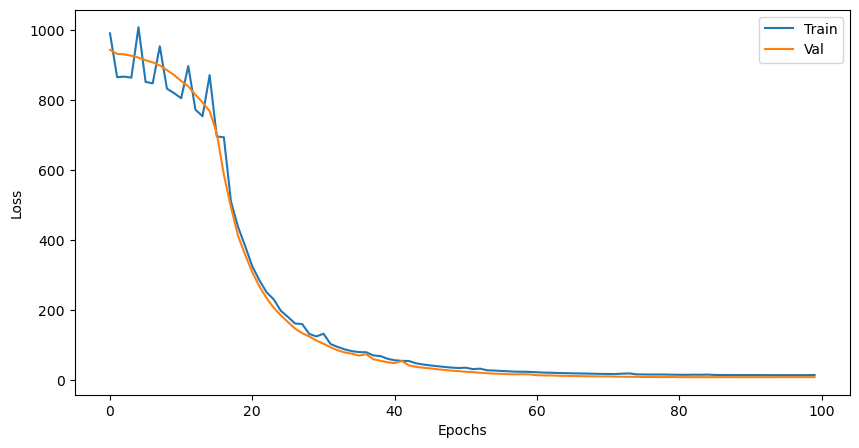

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

In [76]:
# Load the trained weights
model.load_state_dict(torch.load('best_model.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

pred_value = []
actual_value = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.cuda()
        outputs = model(features).squeeze(-1)
        pred_value.append(outputs.cpu())
        actual_value.append(labels)

pred_value = torch.cat(pred_value)
actual_value = torch.cat(actual_value)

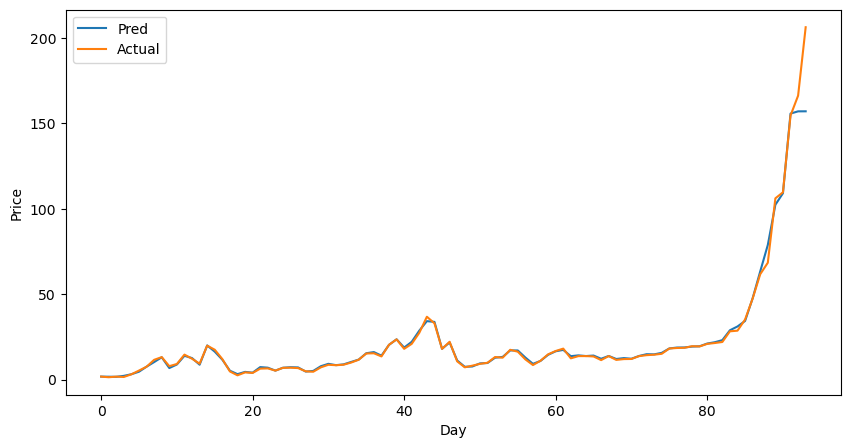

In [77]:
plt.figure(figsize=(10, 5))
plt.plot(pred_value[:])
plt.plot(actual_value[:])
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend(['Pred', 'Actual'])

plt.show()